#Imports and Download custom dataset
1.Custom Dataset download from this [this](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)
2. Basic Imports 

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score
import random
import numpy as np
import tensorflow as tf
from numpy.random import randint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from google.colab.patches import cv2_imshow
import tensorflow_datasets as tfds
%matplotlib inline
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip /content/trainPart1.zip

--2021-04-10 16:04:43--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-10 16:04:43--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc09f0426fa0718708620236e998.dl.dropboxusercontent.com/cd/0/inline/BMXO5-pZxJqbJ5VCxbE01WVunSaC5kRU4_DLGhgGl-BBvbbkPngAYBNLaOJ4EryuddST7O1XWyqAU0XPSwW1rZ5rDFA_s6_yjbcn3_UgnKQOO5k_VwY0CmOj3s4U4q34nRafgFJmE7Jdo_YF4UjywLeB/file# [following]
--2021-04-10 16:04:43--  https://uc09f0426fa0718708620236e998.dl.dropboxusercontent.com/cd/0/inline/BMXO5-pZxJqbJ5VCxbE01WVunSaC5kRU4_DLGhgGl-BBvbbkPngAYBNLaOJ4EryuddST7O1XWyqAU0XPSwW1

#Preprocessing
- ```bounder```: This function extracts the region of interest around the digit/character, since the characters do not fill the entire image
- In the next code block we iterate over the directories and for the supervised examples X and Y. 
- The following preprocessing has been applied to the image
  1. Image is converted to grayscale
  2. pixels are inverted thorugh ``cv2_bitwise``
  3. Images are resized to uniform shape of ``input_shape=(64,64)``
  4. Edges are smoothened using Gaussian Blur
  5. Label vector of dimension ``classes=10`` is formed, for 0-9 digit

In [ ]:
input_shape=(64,64,1) 
par_dir="/content/train"
classes=10
dicti={}

In [ ]:
def bounder(thresh,margin=12):
  sh=thresh.shape
  x_min,x_max,y_min,y_max=10000,-10000,10000,-10000
  for x in range(sh[0]):
    if np.amax(thresh[x])!=0: x_min,x_max=min(x_min,x),max(x_max,x)
  for y in range(sh[1]):
    if np.amax(thresh.T[y])!=0: y_min,y_max=min(y_min,y),max(y_max,y)
  return thresh[max(x_min-margin,0):min(x_max+margin,sh[1]),max(y_min-margin,0):min(y_max+margin,sh[1])]

In [ ]:
X,Y = [],[]
for foldername in os.listdir(par_dir):
  if int(foldername[-2:])-1>9: continue
  for filename in os.listdir(par_dir+"/"+str(foldername)):
    filepath=par_dir+"/"+str(foldername)+"/"+str(filename)
    image=cv2.imread(filepath)
    thresh = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_not(thresh)
    thresh=cv2.GaussianBlur(cv2.resize(bounder(thresh),(64,64)), (3, 3), 0)
    X.append(thresh)
    vec=np.zeros(classes)
    dicti[int(foldername[-2:])-1]=thresh
    vec[int(foldername[-2:])-1]=1
    Y.append(vec) 
X=np.expand_dims(np.array(X),3)
Y=np.array(Y)

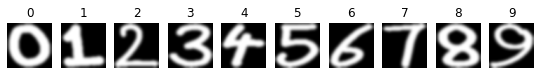

In [ ]:
plt.figure(figsize=(20,4))
for i,k in enumerate(sorted(dicti.keys())):
  plt.subplot(3,21,i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(dicti[k]),'gray')
  plt.title(str(k))

#Training on 0-9 digits from custom dataset

### Model
1. A 70-30 split is performed in the dataset
2. We define a keras data augmenter, ```ImageDataGenerator``` which will augment images on the fly. We resort to only rotating the images.
3. The same Modified LeNet model used earlier for training 62 classes, is used

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.30)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=False)
datagen.fit(X_train)

(280, 64, 64, 1) (280, 10) (120, 64, 64, 1) (120, 10)


In [ ]:
training =False

In [ ]:
def CustomCNN_arch(input_shape = (64, 64, 1), classes = 10):
  model = tf.keras.Sequential([
  Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = input_shape),
  Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),  
  BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25), 
  Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
  Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
  BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25),
  Flatten(name = 'flatten'),
  Dense(units = 256), BatchNormalization(), Activation("relu"),  
  Dense(units = 128), BatchNormalization(), Activation("relu"),
  Dropout(0.25),
  Dense(units = classes, activation = 'softmax')])
  return model
checkpoint_filepath = '/content/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                                               monitor='val_accuracy', mode='max', save_best_only=True)
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 7)
if training:
  model = CustomCNN_arch(input_shape = input_shape, classes = classes)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(datagen.flow(X_train, Y_train, batch_size=32),
            steps_per_epoch=len(X_train) / 32, epochs=100,
            callbacks = [variable_learning_rate,model_checkpoint_callback], validation_data = (X_test,Y_test)) 


In [ ]:
pretrained_model=CustomCNN_arch(input_shape = input_shape, classes = classes)
!wget https://github.com/mh2029/Midas_Task2/blob/main/Weights/Important_weights/point2_customdataset_network_zero2nine.hdf5?raw=true
pretrained_model.load_weights('/content/point2_customdataset_network_zero2nine.hdf5?raw=true')
def accuracy(x_t,y_t):
  predict=np.argmax(pretrained_model.predict(x_t),1)
  act=np.argmax(y_t,-1)
  return accuracy_score(predict,act)
print('Peformance on Validation set: {}'.format(accuracy(X_test,Y_test)))
print('Peformance on Train set: {}'.format(accuracy(X_train,Y_train)))

--2021-04-10 14:07:29--  https://github.com/mh2029/Midas_Task2/blob/main/Weights/Important_weights/point2_customdataset_network_zero2nine.hdf5?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mh2029/Midas_Task2/raw/main/Weights/Important_weights/point2_customdataset_network_zero2nine.hdf5 [following]
--2021-04-10 14:07:29--  https://github.com/mh2029/Midas_Task2/raw/main/Weights/Important_weights/point2_customdataset_network_zero2nine.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Important_weights/point2_customdataset_network_zero2nine.hdf5 [following]
--2021-04-10 14:07:29--  https://raw.githubusercontent.com/mh2029/Midas_Task2/main/Weights/Important_weights/point2_customdataset_network_zero2nin

### It can be seen that network performs vary well with:

**Peformance on Validation set: 1.0**

**Peformance on Train set: 0.9892857142857143**

#Mnist Dataset
1. Downloading it from ```tf.keras.dataset``` it has the same split as provided in official Yaan Lecun website
2. The images have shape of ```28x28``` it is first reshaped to ```64x64```
3. It is passed to the function ``bounder``, which extracts the region of interest, finally it is again reshaped to ``64x64``.

In [ ]:
def onehot(y):
  num_labels=np.size(np.unique(y))
  Y = np.zeros((y.shape[0],num_labels))
  for i in range(y.shape[0]):
    Y[i][y[i]]=1
  return Y
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data(path='mnist.npz')
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
x_train,x_test=list(x_train),list(x_test)
for i in range(len(x_train)):
  img=cv2.resize(x_train[i],(64,64))
  img=bounder(img,2)
  x_train[i]=cv2.resize(img,(64,64))
for i in range(len(x_test)):
  img=cv2.resize(x_test[i],(64,64))
  img=bounder(img,2)
  x_test[i]=cv2.resize(img,(64,64))
x_test,x_train,y_test,y_train=np.expand_dims(np.array(x_test),3),np.expand_dims(np.array(x_train),3),onehot(y_test),onehot(y_train)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 64, 64, 1) (10000, 64, 64, 1) (60000, 10) (10000, 10)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20)

In [ ]:
sete=set()
plt.figure(figsize=(10,5))
for i in range(x_train.shape[0]):
  if np.argmax(y_train[i]) not in sete:
    sete.add(np.argmax(y_train[i]))
    plt.subplot(3,21,i+1)
    plt.imshow(np.squeeze(x_train[i]))
    plt.title(str(np.argmax(y_train[i])))

**Evaluating performance of pretrained netowrk without any training on MNIST**

In [ ]:
def accuracy(x_t,y_t):
  predict=np.argmax(pretrained_model.predict(x_t),1)
  act=np.argmax(y_t,-1)
  return accuracy_score(predict,act)
print('Peformance on MNIST test set, with no training on MNIST train set: {}'.format(accuracy(x_test,y_test)))

Peformance on MNIST test set, with no training on MNIST train set: 0.7349


## Training network with randomly initialized weights on MNIST

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=False)
datagen.fit(x_train)
random_initmodel=CustomCNN_arch(input_shape = input_shape, classes = classes)
random_initmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)
history1=random_initmodel.fit(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) / 32, epochs=20, validation_data = (x_val,y_val)) 

Epoch 1/20
1500/1500 [==============================] - 30s 19ms/step - loss: 0.3747 - accuracy: 0.8867 - val_loss: 0.0704 - val_accuracy: 0.9801
Epoch 2/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1060 - accuracy: 0.9685 - val_loss: 0.0559 - val_accuracy: 0.9822
Epoch 3/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0788 - accuracy: 0.9749 - val_loss: 0.0536 - val_accuracy: 0.9845
Epoch 4/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0696 - accuracy: 0.9784 - val_loss: 0.0399 - val_accuracy: 0.9881
Epoch 5/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0626 - accuracy: 0.9807 - val_loss: 0.0507 - val_accuracy: 0.9859
Epoch 6/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.0334 - val_accuracy: 0.9890
Epoch 7/20
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0495 - accuracy: 0.9842 - val_loss: 0.0484 -

In [ ]:
random_initmodel.save_weights('point2_mnist_randomweights.h5')
random_initmodel.load_weights('point2_mnist_randomweights.h5')

## Training network with pre-trained weights on MNIST

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, horizontal_flip=False)
datagen.fit(x_train)
pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pretrained_model.load_weights('/content/point2_customdataset_network_zero2nine.hdf5?raw=true')
history2=pretrained_model.fit(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) / 32, epochs=20, validation_data = (x_val,y_val)) 

Epoch 1/20
1500/1500 [==============================] - 29s 19ms/step - loss: 0.2331 - accuracy: 0.9298 - val_loss: 0.0721 - val_accuracy: 0.9783
Epoch 2/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0926 - accuracy: 0.9718 - val_loss: 0.0671 - val_accuracy: 0.9806
Epoch 3/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0788 - accuracy: 0.9761 - val_loss: 0.0582 - val_accuracy: 0.9826
Epoch 4/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0657 - accuracy: 0.9798 - val_loss: 0.0438 - val_accuracy: 0.9873
Epoch 5/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0549 - accuracy: 0.9832 - val_loss: 0.0419 - val_accuracy: 0.9885
Epoch 6/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0524 - accuracy: 0.9840 - val_loss: 0.0365 - val_accuracy: 0.9889
Epoch 7/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.0532 -

In [ ]:
pretrained_model.save_weights('point2_mnisttrainedon_pretrain.h5')
pretrained_model.load_weights('point2_mnisttrainedon_pretrain.h5')

## Comparing the performance of both networks



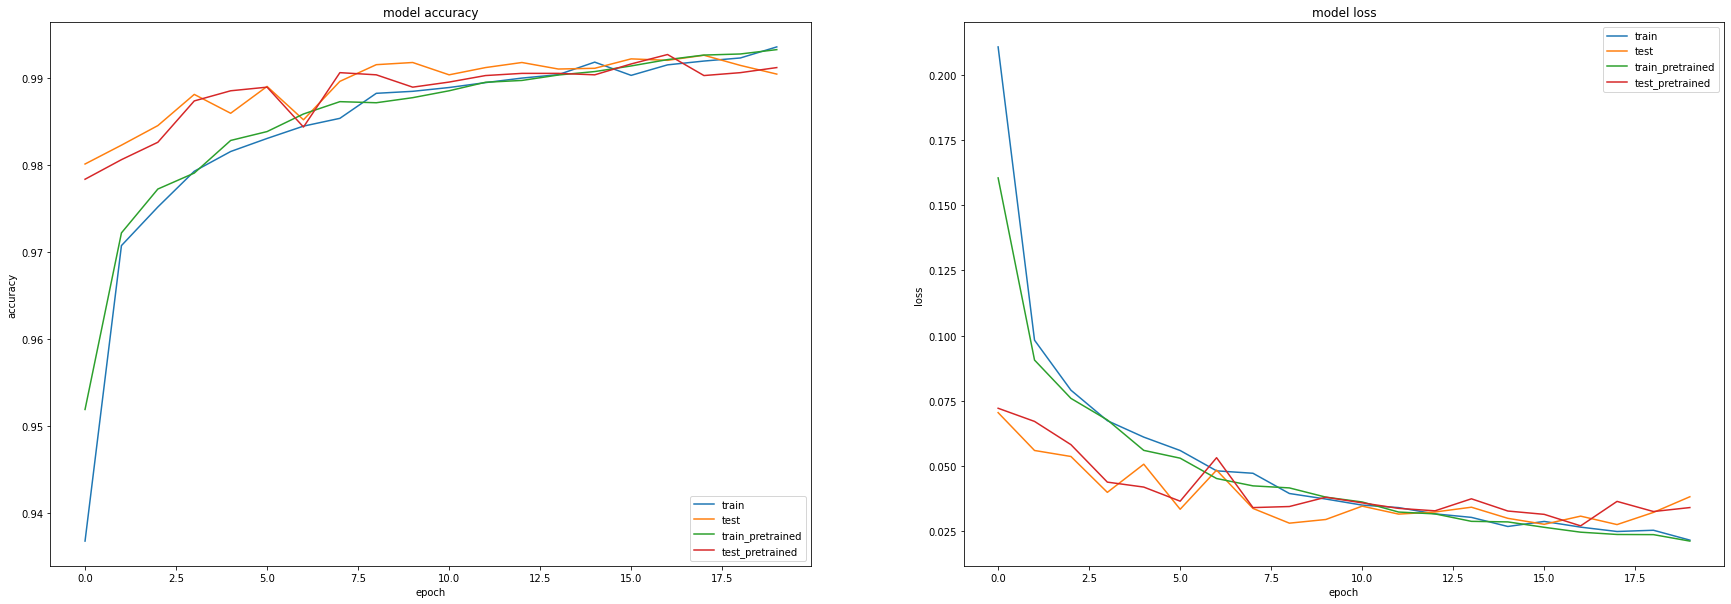

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test','train_pretrained', 'test_pretrained'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test','train_pretrained', 'test_pretrained'], loc='upper right')

It can be seen that the pretrained model start off with a smaller loss and higher accuracy. This converges few epochs earlier than randomly initialized model